## HW2 Solution Part 1

**step1**: get keypoints for each images

**step2**: get patches for each keypoints

**step3**: get descriptions for each keypoints (by forward pass patches to the network)

step4: caculate the similarity matrices

step5: get topK similar images for each query

step6: draw recall vs precision curves

---

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
# load packages
from __future__ import division, print_function
import glob
import os
import cv2
import PIL
import random
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.init
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.autograd import Variable
from copy import deepcopy, copy
from Utils import cv2_scale36, cv2_scale, np_reshape, np_reshape64
from scipy.optimize import linear_sum_assignment
np.set_printoptions(suppress=True)



# Compute the fundamental matrix F for the manually selected keypoints

First, generation of the C0 matrices for each pairs 

In [3]:
# Image 11 and 12
x11 = [[143, 232, 1],[16, 400, 1],[59, 480, 1],[167, 500, 1],[363, 569, 1],[597, 411, 1],
        [447, 641, 1],[879, 50, 1], [781, 528, 1],[779, 636, 1]]
x12 = [[179, 236, 1], [59, 400, 1], [97, 480, 1], [195, 498, 1], [380, 571, 1], [609, 413, 1],
        [461, 643, 1], [892, 49, 1], [782, 530, 1], [779, 638, 1]]

C01 = [[],[],[],[],[],[],[],[],[],[]]
for j in range(0,10):
    for i in range(0,10):
        C01[j].append([x11[i],x12[j]])

# Image 21 and 22

x21 = [[16, 183, 1], [334, 180, 1], [374, 143, 1], [558, 194, 1], [423, 240, 1], [603, 441, 1], 
       [309, 434, 1], [94, 329, 1],
       [354, 323, 1], [188, 216, 1]]
x22 = [[52, 182, 1], [365, 180, 1], [408, 142, 1], [594, 194, 1], [454, 239, 1], [621, 440, 1], 
       [321, 433, 1], [113, 327, 1],
       [380, 322, 1], [219, 214, 1]]

C02 = [[],[],[],[],[],[],[],[],[],[]]
for j in range(0,10):        
    for i in range(0,10):
        C02[j].append([x21[i],x22[j]])


# Image 31 and 32

x31 = [[205, 185, 1], [254, 294, 1], [426, 125, 1], [77, 128, 1], [426, 125, 1], [183, 149, 1], 
       [227, 149, 1],
        [276, 85, 1], [111, 43, 1], [249, 81, 1]]
x32 = [[200, 184, 1], [237, 293, 1],[392, 126, 1], [426, 125, 1], [40, 128, 1], [172, 149, 1], 
       [215, 149, 1], [243, 85, 1], 
       [77, 43, 1],[261, 81, 1]]

C03 = [[],[],[],[],[],[],[],[],[],[]]
for j in range(0,10):
    for i in range(0,10):
        C03[j].append([x31[i],x32[j]])

# Image 41 and 42

x41 = [[44, 198, 1], [380, 113, 1], [481, 147, 1], [356, 621, 1], [302, 668, 1], [263, 416, 1], 
       [83, 435, 1], [377, 663, 1],
       [159, 373, 1],[105, 560, 1]]
x42 = [[32, 200, 1], [415, 109, 1], [523, 150, 1], [469, 660, 1], [422, 719, 1], [299, 431, 1], 
       [78, 460, 1], [522, 713, 1],
       [170, 382, 1], [106, 613, 1]]

C04 = [[],[],[],[],[],[],[],[],[],[]]
for j in range(0,10):
    for i in range(0,10):
        C04[j].append([x41[i],x42[j]])

# Image 51 and 52
x51 = [[704, 73, 1], [512, 464, 1], [960, 442, 1], [887, 1260, 1], [893, 439, 1], [69, 902, 1], 
       [1079, 1239, 1], [531, 948, 1], 
       [105, 1088, 1], [1210, 975, 1]]
x52 = [[774, 80, 1], [583, 469, 1], [1014, 446, 1], [939, 1260, 1], [946, 442, 1], [142, 904, 1],
       [1152, 1239, 1], [602, 950, 1],
       [171, 1088, 1],[1286, 975, 1]]

C05 = [[],[],[],[],[],[],[],[],[],[]]
for j in range(0,10):
    for i in range(0,10):
        C05[j].append([x51[i],x52[j]])

C0 = np.zeros((5,10,2,3))
for m in range(5):
    if m == 0:
        C0_nb = C01
    if m == 1:
        C0_nb = C02
    if m == 2:
        C0_nb = C03
    if m == 3:
        C0_nb = C04
    if m == 4:
        C0_nb = C05
    for i in range(10):
        C0[m][i][0]= C0_nb[i][i][0]
        C0[m][i][1]= C0_nb[i][i][1]


print(len(C0))
#print(C0)
torch.save(C0, "results/C0_manual_coordinates_100.pt")

# Coordinates of the keypoints for each image 1 of the five pairs
X1 = x11, x21, x31, x41, x51
# Coordinates of the keypoints for each image 2 of the five pairs
X2 = x12, x22, x32, x42, x52

5


### Compute the Fundamental Matrix F0 based on C0 using: W*f = 0

In [4]:
W = np.zeros((10, 9))

for m in range(0, 5):
    for i in range(0, 10):
        W[i, 0]= X1[m][i][0]*X2[m][i][0]
        W[i, 1]= X1[m][i][0]*X2[m][i][1]
        W[i, 2]= X1[m][i][0]
        W[i, 3]= X1[m][i][1]*X2[m][i][0]
        W[i, 4]= X1[m][i][1]*X2[m][i][1]
        W[i, 5]= X1[m][i][1]
        W[i, 6]= X2[m][i][0]
        W[i, 7]= X2[m][i][1]
        W[i,8]=1
    print("\nImage {}: W matrix\n".format(m+1))
    print(W)
    print('__ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __')

    # SVD
    u, s, vh = np.linalg.svd(W, full_matrices=True)
    # last row of V = last column V transposed

    f = vh[-1]
    print("\nf = last column V transposed \n")
    print(f)

    F = np.zeros((3,3))

    for i in range(0,3):
        for j in range(0,3):
            F[i,j]=f[i*3+j]

    print("\nImage {}: Fundamental Matrix F0\n".format(m+1))
    print(F)
    torch.save(F, "results/fundamental_matrix_0_images_pair_{}".format(m+1))
    print('____________________________________________________________________________________')




Image 1: W matrix

[[ 25597.  33748.    143.  41528.  54752.    232.    179.    236.      1.]
 [   944.   6400.     16.  23600. 160000.    400.     59.    400.      1.]
 [  5723.  28320.     59.  46560. 230400.    480.     97.    480.      1.]
 [ 32565.  83166.    167.  97500. 249000.    500.    195.    498.      1.]
 [137940. 207273.    363. 216220. 324899.    569.    380.    571.      1.]
 [363573. 246561.    597. 250299. 169743.    411.    609.    413.      1.]
 [206067. 287421.    447. 295501. 412163.    641.    461.    643.      1.]
 [784068.  43071.    879.  44600.   2450.     50.    892.     49.      1.]
 [610742. 413930.    781. 412896. 279840.    528.    782.    530.      1.]
 [606841. 497002.    779. 495444. 405768.    636.    779.    638.      1.]]
__ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __

f = last column V transposed 

[-0.00000012  0.00004452 -0.02110133 -0.00004641 -0.00000091  0.01201702
  0.02204132 -0.00950205 -0.999416

## Detect 100 strongest interest points (SIFT) in each image, then, compute their deep features, and finally match them one-to-one


In [5]:
# parameters setting
query_path = "stereo/image1/"
image_path = "stereo/image2/"
query_num = 5
image_num = 5
kps_num = 100 #number of keypoints we want to detect 
patch_size = 32
patches = torch.zeros(query_num+image_num, kps_num,1, patch_size, patch_size)

In [6]:
# Initiate SURF detector
surf = cv2.xfeatures2d.SURF_create(kps_num)

In [7]:
def getPatches(kps, img, size=32, num=500):
    res = torch.zeros(num, 1, size, size)
    if type(img) is np.ndarray:
        img = torch.from_numpy(img)
    h, w = img.shape      # note: for image, the x direction is the verticle, y-direction is the horizontal...
    for i in range(num):
        cx, cy = kps[i]
        cx, cy = int(cx), int(cy)
        dd = int(size/2)
        xmin, xmax = max(0, cx - dd), min(w, cx + dd ) - 1
        ymin, ymax = max(0, cy - dd), min(h, cy + dd ) - 1 
        
        xmin_res, xmax_res = dd - min(dd,cx), dd + min(dd, w - cx)-1
        ymin_res, ymax_res = dd - min(dd,cy), dd + min(dd, h - cy)-1

        res[i, 0, ymin_res: ymax_res, xmin_res: xmax_res] = img[ymin: ymax, xmin: xmax]
    return res

Images 1: coordinates pi


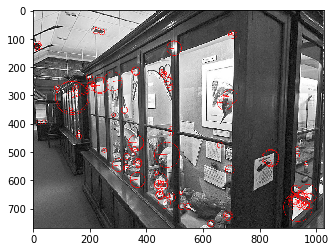

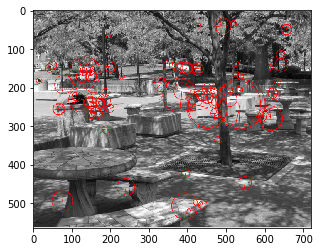

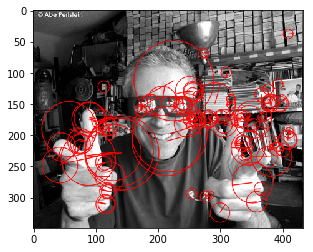

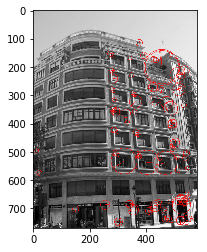

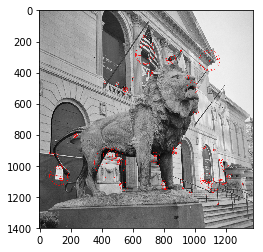

Images 2: coordinates qi


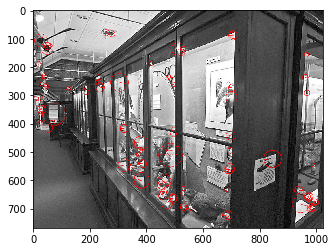

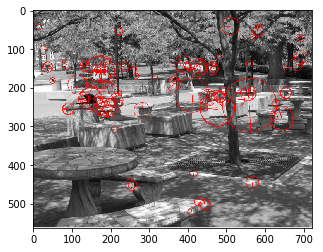

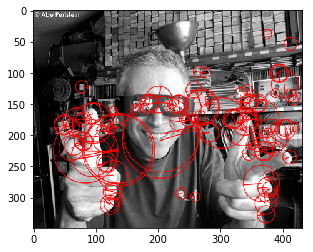

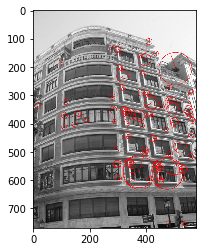

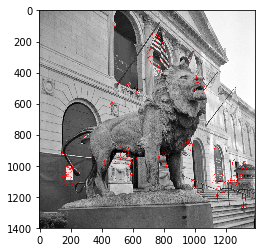

torch.Size([10, 100, 1, 32, 32])


In [28]:
# tensor for query/image patches
save = False
for idx in range(query_num+image_num):
    if idx == 0:
        print('Images 1: coordinates pi')
    if idx == query_num:
        print('Images 2: coordinates qi')
    if idx < query_num:
        img_dir = os.path.join(query_path,"image{}.png".format(idx+1))
    else:
        img_dir = os.path.join(image_path,"image{}.png".format(idx+1-query_num))
    image = cv2.imread(img_dir)
    img= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ## find the keypoints and descriptors with SURF
    kps, des = surf.detectAndCompute(img, None)
    keypoints_img = [kps[a].pt for a in range(kps_num)] 
    keypoints_img2 = [kps[a] for a in range(kps_num)] 
    patches[idx] = getPatches(keypoints_img, img, size=patch_size, num=kps_num)
    
    ## plot keypoints on each image
    img2 = cv2.drawKeypoints(img, keypoints_img2, None, color=(255,0,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img2)
    plt.show()
    # Saving the coordinates (x,y) of the detected keypoints
    if save:
        if idx < query_num:
            torch.save(keypoints_img, "results/detected_SIFT_keypoints_coordinates_image1_{}.pt".format(idx+1))
        else:
            torch.save(keypoints_img, "results/detected_SIFT_keypoints_coordinates_image2_{}.pt".format(idx+1-query_num))
        output_dir_patches = "results/keypoints_patches_images.pt"
        torch.save(patches, output_dir_patches)
        
print(patches.shape)


In [ ]:
### Load the coordinates of the detected keypoints (using SIFT)

In [8]:
keypoints_coordinates_11 = torch.load("results/detected_SIFT_keypoints_coordinates_image1_1.pt")
keypoints_coordinates_12 = torch.load("results/detected_SIFT_keypoints_coordinates_image1_2.pt")
keypoints_coordinates_13 = torch.load("results/detected_SIFT_keypoints_coordinates_image1_3.pt")
keypoints_coordinates_14 = torch.load("results/detected_SIFT_keypoints_coordinates_image1_4.pt")
keypoints_coordinates_15 = torch.load("results/detected_SIFT_keypoints_coordinates_image1_5.pt")
print(len(keypoints_coordinates_11)) # = 100
keypoints_coordinates_21 = torch.load("results/detected_SIFT_keypoints_coordinates_image2_1.pt")
keypoints_coordinates_22 = torch.load("results/detected_SIFT_keypoints_coordinates_image2_2.pt")
keypoints_coordinates_23 = torch.load("results/detected_SIFT_keypoints_coordinates_image2_3.pt")
keypoints_coordinates_24 = torch.load("results/detected_SIFT_keypoints_coordinates_image2_4.pt")
keypoints_coordinates_25 = torch.load("results/detected_SIFT_keypoints_coordinates_image2_5.pt")
#print(keypoints_coordinates_12)

# IMAGES 1
keypoints_coordinates_p = [keypoints_coordinates_11],[keypoints_coordinates_12],[keypoints_coordinates_13],[keypoints_coordinates_14],[keypoints_coordinates_15]

# IMAGES 2
keypoints_coordinates_q = [keypoints_coordinates_21],[keypoints_coordinates_22],[keypoints_coordinates_23],[keypoints_coordinates_24],[keypoints_coordinates_25]

keypoints_coordinates = torch.zeros(query_num+image_num,2, kps_num, 3)
print(len(keypoints_coordinates_p)) # =5
print(len(keypoints_coordinates_q)) # =5
print(len(keypoints_coordinates_q[0][0])) # =100

#print(keypoints_coordinates_p[0][0][1])



100
5
5
100


## Import pre-trained CNN

In [42]:
# import network, load pretrained weights, and turn on testing mode
from descriptor_CNN3 import DesNet
model = DesNet()
model.cuda()
model.eval()
trained_weights = torch.load("checkpoint.pth")
model.load_state_dict(trained_weights["state_dict"])

In [43]:
# Load the patches 
patches_dir_images = "results/keypoints_patches_images.pt"
patches = torch.load(patches_dir_images)
print(patches.shape)

torch.Size([10, 100, 1, 32, 32])


## Getting the keypoints descriptions using the previously imported CNN  

In [44]:
model.eval()
with torch.no_grad():
    des1 = model(patches[:query_num].view(-1, 1, patch_size,patch_size).cuda()).view(-1, kps_num, 128)
    des2 = model(patches[query_num:].view(-1, 1, patch_size,patch_size).cuda()).view(-1, kps_num, 128)

In [45]:
print(des1.shape)  # [number of images, number of keypoints, 128]
print(des2.shape)  # [number of images, number of keypoints, 128]
# save keypoints descriptions into a pytorch file
des_dir = "results/images_keypoints_descriptions.pt"
#torch.save(description_images, des_dir)
# save descriptions 
#print(des1)
torch.save([des1, des2], des_dir)

torch.Size([5, 100, 128])
torch.Size([5, 100, 128])


# Getting one to one similitude matrix

In [13]:
[des1, des2] = torch.load(des_dir)
print(des1.shape)
print(des2.shape)
#print(images_description)

torch.Size([5, 100, 128])
torch.Size([5, 100, 128])


In [47]:
print(keypoints_coordinates_p[0][0][99])
print(keypoints_coordinates_p[0][0][1])
#keypoints_coordinates_p[number of the pair][?][number of the (x,y)]
#print(keypoints_coordinates_p)

(138.15528869628906, 308.47613525390625)
(447.8544921875, 639.9784545898438)


## Hungarian 

In [48]:
save = False
from munkres import Munkres
C_onetoone = np.zeros((5,100,2,3))
sim_matrix = np.zeros((5,5))

for qkeypoint in range(5):
    for images_keypoint in range(5):
        cost_matrix = np.zeros((100, 100))
        for i in range(100):
            for j in range(100):
                cost_matrix[i][j] = np.linalg.norm(des1[qkeypoint][i].cpu().numpy() - des2[images_keypoint][j].cpu().numpy())
        # Hungarian: one-to-one matching
        m = Munkres()
        indexes = m.compute(np.copy(cost_matrix))
        
        for m in indexes:
                sim_matrix[qkeypoint, images_keypoint] += np.exp(-cost_matrix[m])

        for m in range(0,len(indexes)):
                C_onetoone[qkeypoint][m][0][0] = keypoints_coordinates_p[qkeypoint][0][indexes[m][0]][0]
                C_onetoone[qkeypoint][m][0][1] = keypoints_coordinates_p[qkeypoint][0][indexes[m][0]][1]
                C_onetoone[qkeypoint][m][0][2] = 1
                C_onetoone[qkeypoint][m][1][0] = keypoints_coordinates_q[qkeypoint][0][indexes[m][1]][0]
                C_onetoone[qkeypoint][m][1][1] = keypoints_coordinates_q[qkeypoint][0][indexes[m][1]][1]
                C_onetoone[qkeypoint][m][1][2] = 1
            
print(C_onetoone)
if save: 
    torch.save(C_onetoone, "results/C_onetoone_coordinates_100.pt")
    
    

[[[[ 198.18803406  235.29318237    1.        ]
   [ 697.60070801  495.41763306    1.        ]]

  [[ 447.85449219  639.97845459    1.        ]
   [ 960.98742676  236.78692627    1.        ]]

  [[  19.95652008  395.08258057    1.        ]
   [ 707.56115723   86.87532043    1.        ]]

  ...

  [[ 132.99514771  347.67245483    1.        ]
   [  31.66464424  259.91995239    1.        ]]

  [[ 322.2756958   352.46789551    1.        ]
   [ 555.56109619  694.80975342    1.        ]]

  [[ 138.1552887   308.47613525    1.        ]
   [ 453.40383911  616.29626465    1.        ]]]


 [[[ 130.47540283  158.40396118    1.        ]
   [ 409.76556396  520.99810791    1.        ]]

  [[ 146.87660217  158.2979126     1.        ]
   [ 259.27926636  152.04721069    1.        ]]

  [[ 108.62760162  234.52099609    1.        ]
   [ 443.29556274  501.90734863    1.        ]]

  ...

  [[ 155.92417908  238.86587524    1.        ]
   [ 434.40997314  148.0977478     1.        ]]

  [[ 199.24328613  254.1

### Check the cost and similitude matrices

In [49]:
print('Cost matrix\n')
print(cost_matrix)
print(cost_matrix.shape)
print('\n-----------------------------------------------\n')
print('Similitude matrix\n')
print(sim_matrix)
print(sim_matrix.shape)
print('The matching one to one is correct if the highest values are the diagonal ones')


Cost matrix

[[1.07105947 1.07105947 0.29357091 ... 1.42162728 0.92484719 1.32912803]
 [0.26871565 0.26871568 1.0388993  ... 1.1980685  1.10351861 1.17367041]
 [0.26871568 0.26871568 1.0388993  ... 1.1980685  1.10351861 1.17367041]
 ...
 [1.18849492 1.18849492 1.33453071 ... 1.48261297 1.34418797 1.16350985]
 [1.0786947  1.0786947  1.25028741 ... 1.29727137 1.22633028 1.18396795]
 [1.27808917 1.27808917 1.33976698 ... 1.44743574 1.23740435 1.16258049]]
(100, 100)

-----------------------------------------------

Similitude matrix

[[52.48320967 34.67443357 34.15875957 32.77625998 35.501533  ]
 [34.77722952 60.10870569 34.37093128 33.26215063 34.61884151]
 [34.05201469 33.92104223 48.50168571 33.47446545 34.66774887]
 [33.50170963 33.89448364 33.57659914 46.17897671 33.46480992]
 [35.32090112 34.74653273 34.35425259 33.14839452 57.25964678]]
(5, 5)
The matching one to one is correct if the highest values are the diagonal ones


In [50]:
# save matrices cost & similitude
cost_one2one_dir = "results/cost_one2one.pt"
torch.save(cost_matrix, cost_one2one_dir)
similarity_one2one_dir = "results/similarity_one2one.pt"
torch.save(sim_matrix, similarity_one2one_dir)

## Automatically select 30  pairs for which the fundamental equation closely holds:

In [52]:
C = torch.load("results/C_onetoone_coordinates_100.pt")
print(C.shape)
print(C[0][0]) #p1q1
print(C[0][0][0]) #p1 
print(C[0][0][1]) #q1

(5, 100, 2, 3)
[[198.18803406 235.29318237   1.        ]
 [697.60070801 495.41763306   1.        ]]
[198.18803406 235.29318237   1.        ]
[697.60070801 495.41763306   1.        ]


In [9]:
# Loading the fundamental matrices estimated using the n=10  manually selected pairs of points
F01 = torch.load("results/fundamental_matrix_0_images_pair_1")
F02 = torch.load("results/fundamental_matrix_0_images_pair_2")
F03 = torch.load("results/fundamental_matrix_0_images_pair_3")
F04 = torch.load("results/fundamental_matrix_0_images_pair_4")
F05 = torch.load("results/fundamental_matrix_0_images_pair_5")
#print(F01)
#print(F05)

In [57]:
C1 = np.zeros((5,30,2,3))

for m in range(0,5):
    if m == 0:
        F=F01
        epsilon = -4
    if m == 1:
        F=F02
        epsilon = -2
    if m == 2:
        F=F03
        epsilon = -1.9
    if m == 3:
        F=F04
        epsilon = -3.5
    if m == 4:
        F=F05
        epsilon = -0.6
    nb=0
    for i in range(0,100):
        if np.dot(np.dot(C[m][i][1].T,F05),C[m][i][0]) < epsilon:
            nb = nb +1
            #print(C[m][i])
            C1[m][nb-1]=C[m][i]
    print(nb)
print(C1)
torch.save(C1, "results/C1_onetoone_coordinates_30.pt")

30
30
30
30
30
[[[[ 198.18803406  235.29318237    1.        ]
   [ 697.60070801  495.41763306    1.        ]]

  [[ 151.84648132  269.54605103    1.        ]
   [ 380.75909424  468.56869507    1.        ]]

  [[ 357.39599609  490.65994263    1.        ]
   [ 495.80950928  664.60174561    1.        ]]

  [[ 369.07720947  538.50189209    1.        ]
   [ 937.47790527  633.36682129    1.        ]]

  [[ 484.91217041  233.06341553    1.        ]
   [ 985.58648682  695.65802002    1.        ]]

  [[ 205.40028381  268.4831543     1.        ]
   [ 531.67004395  693.41412354    1.        ]]

  [[ 459.82611084  230.65356445    1.        ]
   [ 496.89382935  418.96643066    1.        ]]

  [[ 221.33522034   71.965271      1.        ]
   [ 705.9465332    88.23805237    1.        ]]

  [[ 497.26287842  134.50563049    1.        ]
   [ 473.28646851  617.69476318    1.        ]]

  [[  21.12809944  128.42901611    1.        ]
   [ 415.98190308  188.4287262     1.        ]]

  [[ 206.3963623   267.87

### Add C0 to C1: C_computed_40 = C0 + C1

In [10]:
C1 = torch.load("results/C1_onetoone_coordinates_30.pt")
C0 = torch.load("results/C0_manual_coordinates_100.pt") 
C_computed_40 = np.zeros((5,40,2,3))

print(len(C0[0])) # = 10
print(len(C1[0])) # = 30

for m in range(5):
    for i in range(40):
        if i < 10:
            C_computed_40[m][i][0][0] = C0[m][i][0][0]
            C_computed_40[m][i][0][1] = C0[m][i][0][1]
            C_computed_40[m][i][0][2] = 1
            C_computed_40[m][i][1][0] = C0[m][i][1][0]
            C_computed_40[m][i][1][1] = C0[m][i][1][1]
            C_computed_40[m][i][1][2] = 1

        else:
            C_computed_40[m][i][0][0] = C1[m][i-10][0][0]
            C_computed_40[m][i][0][1] = C1[m][i-10][0][1]
            C_computed_40[m][i][0][2] = 1
            C_computed_40[m][i][1][0] = C1[m][i-10][1][0]
            C_computed_40[m][i][1][1] = C1[m][i-10][1][1]
            C_computed_40[m][i][1][2] = 1

print(len(C_computed_40[0])) # = 40
print(C_computed_40[0][39]) 
print(C1[0][29]) 
#torch.save(C_computed_40, "results/C_augmented_manual_onetoone_and_coordinates_40.pt")

10
30
40
[[138.1552887  308.47613525   1.        ]
 [453.40383911 616.29626465   1.        ]]
[[138.1552887  308.47613525   1.        ]
 [453.40383911 616.29626465   1.        ]]


In [11]:
C_40 = torch.load("results/C_augmented_manual_onetoone_and_coordinates_40.pt") 
print(C_40[0][1])
print('------ Should be the same as: --------')
#print(C0[0][1][0][0])
print(C0[0][1])
print('____________________________________________')
print(C_40[0][10])
print('------ Should be the same as: --------')
print(C1[0][0])


[[ 16. 400.   1.]
 [ 59. 400.   1.]]
------ Should be the same as: --------
[[ 16. 400.   1.]
 [ 59. 400.   1.]]
____________________________________________
[[198.18803406 235.29318237   1.        ]
 [697.60070801 495.41763306   1.        ]]
------ Should be the same as: --------
[[198.18803406 235.29318237   1.        ]
 [697.60070801 495.41763306   1.        ]]


### Re estimate F1 based on C_40

In [12]:
W1 = np.zeros((40, 9))

for m in range(0, 5):
    for j in range(0,40):
        #W1[i, 0]= C_40[m][i][0][0][0]*C_40[m][i][0][1]
        W1[j, 0]= C_40[m][j][0][0]*C_40[m][j][1][0]
        W1[j, 1]= C_40[m][j][0][0]*C_40[m][j][1][1]
        W1[j, 2]= C_40[m][j][0][0]
        W1[j, 3]= C_40[m][j][0][1]*C_40[m][j][1][0]
        W1[j, 4]= C_40[m][j][0][1]*C_40[m][j][1][1]
        W1[j, 5]= C_40[m][j][0][1]
        W1[j, 6]= C_40[m][j][1][0]
        W1[j, 7]= C_40[m][j][1][1]
        W1[j,8]=1
    print("\nImage {}: W matrix\n".format(m+1))
    print(len(W1))
    print('__ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __')

    # SVD
    u1, s1, vh1 = np.linalg.svd(W1, full_matrices=True)
    # last row of V = last column V transposed

    f1 = vh1[-1]
    print("\nf = last column V transposed \n")
    print(f1)

    F1 = np.zeros((3,3))

    for i in range(0,3):
        for j in range(0,3):
            F1[i,j]=f1[i*3+j]

    print("\nImage {}: Fundamental Matrix F1\n".format(m+1))
    print(F1)
    torch.save(F1, "results/fundamental_matrix_1_images_pair_{}".format(m+1))
    print('____________________________________________________________________________________')


Image 1: W matrix

40
__ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __

f = last column V transposed 

[ 0.00000068  0.0000006  -0.00083847  0.00000148  0.00000339 -0.00287126
 -0.00078598 -0.00088903  0.99999482]

Image 1: Fundamental Matrix F1

[[ 0.00000068  0.0000006  -0.00083847]
 [ 0.00000148  0.00000339 -0.00287126]
 [-0.00078598 -0.00088903  0.99999482]]
____________________________________________________________________________________

Image 2: W matrix

40
__ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __

f = last column V transposed 

[ 0.00000097  0.00000165 -0.00114619  0.00000278  0.0000063  -0.00363308
 -0.00084011 -0.00165301  0.99999102]

Image 2: Fundamental Matrix F1

[[ 0.00000097  0.00000165 -0.00114619]
 [ 0.00000278  0.0000063  -0.00363308]
 [-0.00084011 -0.00165301  0.99999102]]
____________________________________________________________________________________

Image 3: W matr

In [13]:
F01 = torch.load("results/fundamental_matrix_0_images_pair_1")
print('F01')
print(F01)

F11 = torch.load("results/fundamental_matrix_1_images_pair_1")
print('F11')
print(F11)


F01
[[-0.00000012  0.00004452 -0.02110133]
 [-0.00004641 -0.00000091  0.01201702]
 [ 0.02204132 -0.00950205 -0.99941694]]
F11
[[ 0.00000068  0.0000006  -0.00083847]
 [ 0.00000148  0.00000339 -0.00287126]
 [-0.00078598 -0.00088903  0.99999482]]


## Epipolar lines

In [13]:
print(X1[0][2])
#print(F01)

l2 = np.dot(F01, X1[0][2])
print(l2)

x1 = -l2[2]/l2[0]
y1 = 0
y2 = -l2[2]/l2[1]
x2 = 0

print(X1[0][2]) # first image, third point
print(X2[0][2]) # first image, third point
#print(C_40[0][2][0])

[59, 480, 1]
[ 0.00025916  0.00883987 -4.25996278]
[59, 480, 1]
[97, 480, 1]


IMAGE 11
Point number 9
Coordinates point selected: (779,636)


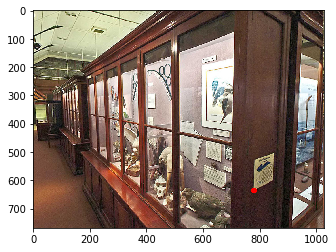

IMAGE 12
Point number 9
Coordinates point selected: (188,216)


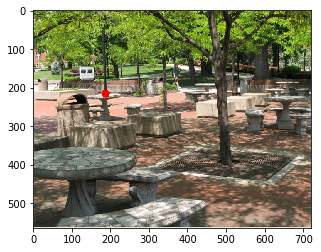

IMAGE 13
Point number 1
Coordinates point selected: (254,294)


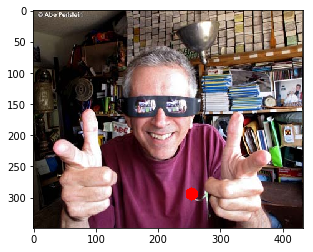

IMAGE 14
Point number 4
Coordinates point selected: (302,668)


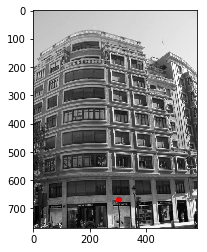

IMAGE 15
Point number 1
Coordinates point selected: (512,464)


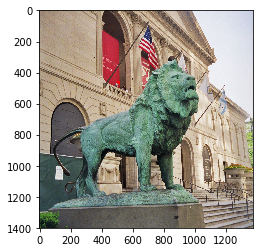

____________________________________________________________
IMAGE 21
0
[-0.00329697  0.01090882 -4.44757557]
[16, 400, 1]
[-0.00058873 -0.00149308  0.63180899]


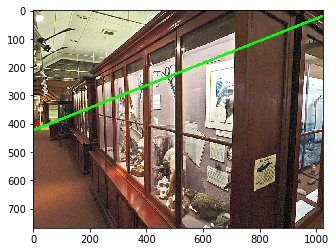

____________________________________________________________
IMAGE 22
1
[-0.00594179  0.00826367  0.30150508]
[334, 180, 1]
[-0.00052443 -0.00157115  0.42185156]


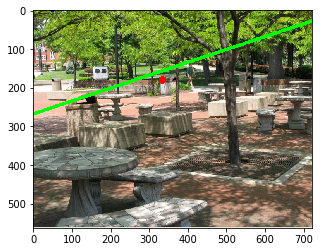

____________________________________________________________
IMAGE 23
2
[-0.02769516 -0.21445175 70.66593779]
[254, 294, 1]
[-0.00031459 -0.00012124  0.09876538]


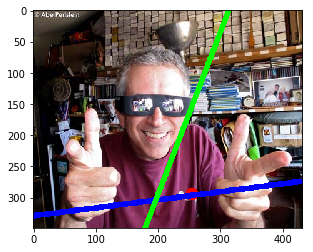

____________________________________________________________
IMAGE 24
3
[-0.06578369 -0.02917006 26.36623826]
[380, 113, 1]
[ 0.00127567  0.00146995 -0.80406961]


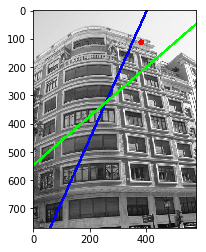

____________________________________________________________
IMAGE 25
4
[-0.00390925 -0.02498171 13.16303792]
[512, 464, 1]
[-0.00033388 -0.00024949  0.36506283]


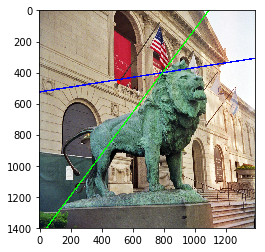

In [35]:
for idx in range(query_num+image_num):
    if idx == 0:
        index_point_selected = 9
    if idx == 1:
        index_point_selected = 9
    if idx == 2:
        index_point_selected = 1
    if idx == 3:
        index_point_selected = 4
    if idx == 4:
        index_point_selected = 1
        
    if idx < query_num:
        print("IMAGE 1{}".format(idx+1))
        img_dir = os.path.join(query_path,"image{}.png".format(idx+1))
        i = idx
        F0 = torch.load("results/fundamental_matrix_0_images_pair_{}".format(idx+1))
        F1 = torch.load("results/fundamental_matrix_1_images_pair_{}".format(idx+1))
        X = X1[i][index_point_selected]
        print("Point number {}".format(index_point_selected))
        print("Coordinates point selected: ({},{})".format(X[0],X[1]))
        image = cv2.imread(img_dir)
        img= cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        cv2.circle(img,(X[0],X[1]), 10, (255,0,0), -1)

    else:
        print('____________________________________________________________')
        print("IMAGE 2{}".format(idx+1-query_num))
        img_dir = os.path.join(image_path,"image{}.png".format(idx+1-query_num))
        F0 = torch.load("results/fundamental_matrix_0_images_pair_{}".format(idx+1-query_num))
        F1 = torch.load("results/fundamental_matrix_1_images_pair_{}".format(idx+1-query_num))
        i = idx+1-query_num-1
        print(i)
        X = X1[i][index_point_selected]
        image = cv2.imread(img_dir)
        img= cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

        l20 = np.dot(F0, X)
        print(l20)

        print(X)
        cv2.circle(img,(X[0],X[1]), 10, (255,0,0), -1)

        x_10 = 0
        y_10 = int((-l20[2])/(l20[1]))
        x_20 = int((-l20[2])/(l20[0]))
        y_20 = 0

        cv2.line(img,(x_10,y_10),(x_20,y_20),(0,0,255),8)


        l21 = np.dot(F1, X)
        print(l21)

        x_11 = 0
        y_11 = int((-l21[2])/(l21[1]))
        x_21 = int((-l21[2])/(l21[0]))
        y_21 = 0

        cv2.line(img,(x_11,y_11),(x_21,y_21),(0,255,0),8)
        

    plt.imshow(img)
    plt.show()
   # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    if idx < query_num:
        cv2.imwrite('pointinimage1_epipolarin2/epipolar_line_image_1{}.png'.format(idx+1),img)
     #   cv2.imwrite('results/epipolar_line_image_1{}.png'.format(idx+1),img)
    else:
     #   cv2.imwrite('results/epipolar_line_image_2{}.png'.format(idx+1-query_num),img)
        cv2.imwrite('pointinimage1_epipolarin2/epipolar_line_image_2{}.png'.format(idx+1-query_num),img)
        


IMAGE 11
Point number 2
Coordinates point selected: (97,480)
[ 0.00025464  0.00707611 -3.42239264]
[97, 480, 1]
(0, 483) (13439, 0)
[-0.00048555 -0.00110258  0.4970223 ]
(0, 450) (1023, 0)


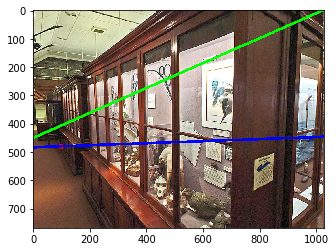

IMAGE 12
Point number 8
Coordinates point selected: (380,322)
[ 0.0066344   0.00325188 -3.41019025]
[380, 322, 1]
(0, 1048) (514, 0)
[-0.00024519 -0.00054876  0.14847938]
(0, 270) (605, 0)


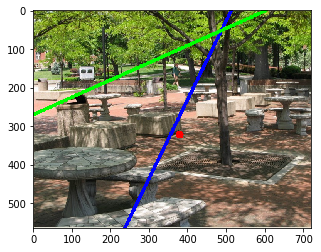

IMAGE 13
Point number 4
Coordinates point selected: (40,128)
[-0.0020772  -0.24213001 31.14755633]
[40, 128, 1]
(0, 128) (14994, 0)
[ 0.00105469  0.00272893 -0.64395425]
(0, 235) (610, 0)


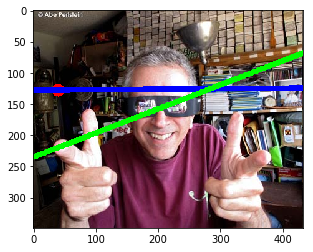

IMAGE 14
Point number 2
Coordinates point selected: (523,150)
[-0.06183392 -0.04243869 35.94563477]
[523, 150, 1]
(0, 847) (581, 0)
[ 0.00117644  0.0014175  -0.74057199]
(0, 522) (629, 0)


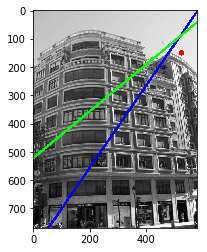

IMAGE 15
Point number 1
Coordinates point selected: (583,469)
[-0.00387725 -0.02543648 13.78089353]
[583, 469, 1]
(0, 541) (3554, 0)
[-0.00029518 -0.00024651  0.32243739]
(0, 1307) (1092, 0)


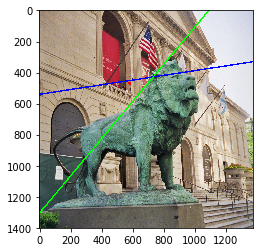

____________________________________________________________
IMAGE 21
0


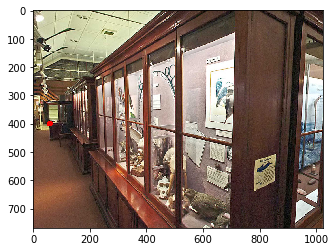

____________________________________________________________
IMAGE 22
1


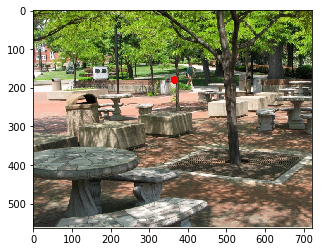

____________________________________________________________
IMAGE 23
2


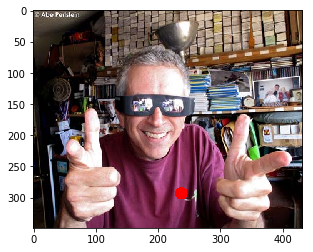

____________________________________________________________
IMAGE 24
3


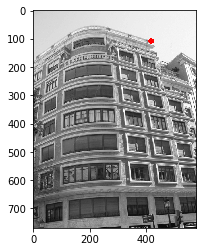

____________________________________________________________
IMAGE 25
4


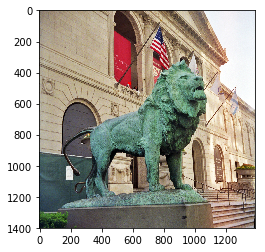

In [24]:
for idx in range(query_num+image_num):
    if idx == 0:
        index_point_selected = 2  
    if idx == 1:
        index_point_selected = 8
    if idx == 2:
        index_point_selected = 4
    if idx == 3:
        index_point_selected = 2
    if idx == 4:
        index_point_selected = 1
        
    if idx < query_num:
        print("IMAGE 1{}".format(idx+1))
        img_dir = os.path.join(query_path,"image{}.png".format(idx+1))
        i = idx
        F0 = torch.load("results/fundamental_matrix_0_images_pair_{}".format(idx+1))
        F1 = torch.load("results/fundamental_matrix_1_images_pair_{}".format(idx+1))
        X = X2[i][index_point_selected]
        print("Point number {}".format(index_point_selected))
        print("Coordinates point selected: ({},{})".format(X[0],X[1]))
        image = cv2.imread(img_dir)
        img= cv2.cvtColor(image,cv2.COLOR_BGR2RGB)        
        
        l20 = np.dot(F0, X)
        print(l20)

        print(X)
        cv2.circle(img,(X[0],X[1]), 10, (255,0,0), -1)

        x_10 = 0
        y_10 = int((-l20[2])/(l20[1]))
        x_20 = int((-l20[2])/(l20[0]))
        y_20 = 0
        print((x_10,y_10),(x_20,y_20))

        cv2.line(img,(x_10,y_10),(x_20,y_20),(0,0,255),8)


        l21 = np.dot(F1, X)
        print(l21)

        x_11 = 0
        y_11 = int((-l21[2])/(l21[1]))
        x_21 = int((-l21[2])/(l21[0]))
        y_21 = 0
        print((x_11,y_11),(x_21,y_21))

        cv2.line(img,(x_11,y_11),(x_21,y_21),(0,255,0),8)

    else:
        print('____________________________________________________________')
        print("IMAGE 2{}".format(idx+1-query_num))
        img_dir = os.path.join(image_path,"image{}.png".format(idx+1-query_num))
        F0 = torch.load("results/fundamental_matrix_0_images_pair_{}".format(idx+1-query_num))
        F1 = torch.load("results/fundamental_matrix_1_images_pair_{}".format(idx+1-query_num))
        i = idx+1-query_num-1
        print(i)
        X = X2[i][index_point_selected]
        image = cv2.imread(img_dir)
        img= cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        cv2.circle(img,(X[0],X[1]), 10, (255,0,0), -1)


    plt.imshow(img)
    plt.show()
   # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    if idx < query_num:
        cv2.imwrite('pointinimage2_epipolarin1/epipolar_line_image_1{}.png'.format(idx+1),img)
     #   cv2.imwrite('results/epipolar_line_image_1{}.png'.format(idx+1),img)
    else:
     #   cv2.imwrite('results/epipolar_line_image_2{}.png'.format(idx+1-query_num),img)
        cv2.imwrite('pointinimage2_epipolarin1/epipolar_line_image_2{}.png'.format(idx+1-query_num),img)
        


## Extra credits

### Use the 100 one-to-one matches of their interest points that you computed for regular HW3, and construct the 100x9 matrix W

In [36]:
C_100 = torch.load("results/C_onetoone_coordinates_100.pt")


In [39]:
W_100 = np.zeros((100, 9))

for m in range(0, 5):
    for j in range(0,100):
        W_100[j, 0]= C_100[m][j][0][0]*C_100[m][j][1][0]
        W_100[j, 1]= C_100[m][j][0][0]*C_100[m][j][1][1]
        W_100[j, 2]= C_100[m][j][0][0]
        W_100[j, 3]= C_100[m][j][0][1]*C_100[m][j][1][0]
        W_100[j, 4]= C_100[m][j][0][1]*C_100[m][j][1][1]
        W_100[j, 5]= C_100[m][j][0][1]
        W_100[j, 6]= C_100[m][j][1][0]
        W_100[j, 7]= C_100[m][j][1][1]
        W_100[j,8]=1
    print("\nImage {}: W matrix\n".format(m+1))
    print(len(W_100))
    print('__ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __')

    # SVD
    u_100, s_100, vh_100 = np.linalg.svd(W_100, full_matrices=True)
    # last row of V = last column V transposed

    f_100 = vh_100[-1]
    print("\nf = last column V transposed \n")
    print(f_100)

    F_100 = np.zeros((3,3))

    for i in range(0,3):
        for j in range(0,3):
            F_100[i,j]=f_100[i*3+j]

    print("\nImage {}: Fundamental Matrix F2\n".format(m+1))
    print(F_100)
    torch.save(F_100, "results/fundamental_matrix_2_images_pair_{}".format(m+1))
    print('____________________________________________________________________________________')


Image 1: W matrix

100
__ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __

f = last column V transposed 

[ 0.00000013  0.00000033 -0.00029917  0.00000076  0.00000224 -0.00155048
 -0.00043499 -0.00143606  0.99999763]

Image 1: Fundamental Matrix F2

[[ 0.00000013  0.00000033 -0.00029917]
 [ 0.00000076  0.00000224 -0.00155048]
 [-0.00043499 -0.00143606  0.99999763]]
____________________________________________________________________________________

Image 2: W matrix

100
__ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __

f = last column V transposed 

[-0.00000121 -0.00000203  0.0010449  -0.00000249 -0.00000556  0.00238585
  0.00109641  0.00221874 -0.99999355]

Image 2: Fundamental Matrix F2

[[-0.00000121 -0.00000203  0.0010449 ]
 [-0.00000249 -0.00000556  0.00238585]
 [ 0.00109641  0.00221874 -0.99999355]]
____________________________________________________________________________________

Image 3: W ma

IMAGE 11
Point number 9
Coordinates point selected: (779,638)
[ 0.00001085  0.00046925 -0.25506504]
[779, 638, 1]
(0, 543) (23502, 0)


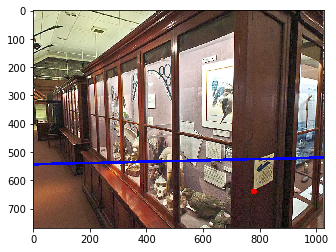

IMAGE 12
Point number 3
Coordinates point selected: (594,194)
[-0.00007014 -0.00017419  0.08171133]
[594, 194, 1]
(0, 469) (1164, 0)


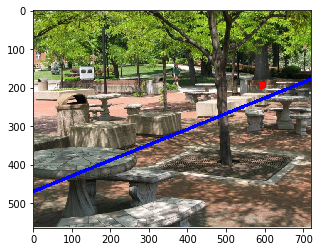

IMAGE 13
Point number 1
Coordinates point selected: (237,293)
[-0.00053429 -0.00105761  0.32756716]
[237, 293, 1]
(0, 309) (613, 0)


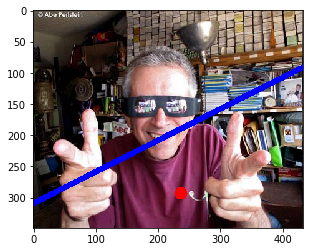

IMAGE 14
Point number 1
Coordinates point selected: (415,109)
[ 0.00032094  0.00017659 -0.23488587]
[415, 109, 1]
(0, 1330) (731, 0)


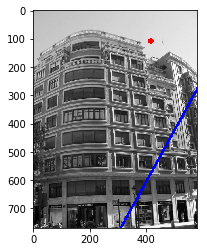

IMAGE 15
Point number 1
Coordinates point selected: (583,469)
[ 0.00030271  0.0000989  -0.32734917]
[583, 469, 1]
(0, 3309) (1081, 0)


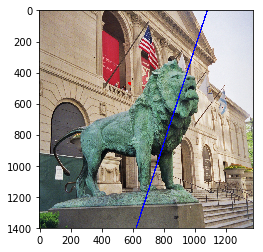

____________________________________________________________
IMAGE 21
0


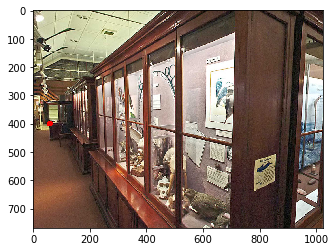

____________________________________________________________
IMAGE 22
1


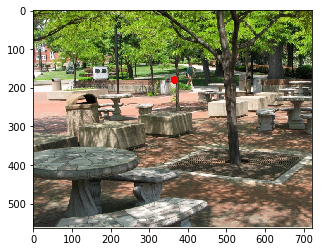

____________________________________________________________
IMAGE 23
2


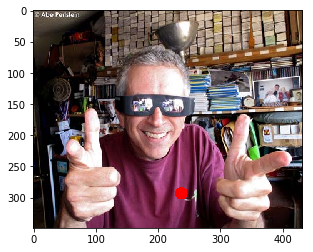

____________________________________________________________
IMAGE 24
3


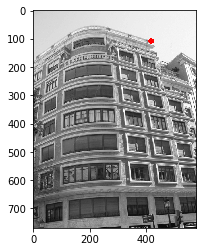

____________________________________________________________
IMAGE 25
4


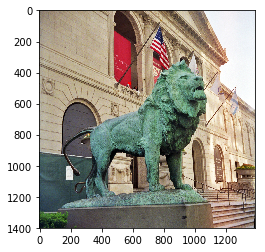

In [49]:
for idx in range(query_num+image_num):
    if idx == 0:
        index_point_selected = 9
    if idx == 1:
        index_point_selected = 3
    if idx == 2:
        index_point_selected = 1
    if idx == 3:
        index_point_selected = 1
    if idx == 4:
        index_point_selected = 1
        
    if idx < query_num:
        print("IMAGE 1{}".format(idx+1))
        img_dir = os.path.join(query_path,"image{}.png".format(idx+1))
        i = idx
      #  F0 = torch.load("results/fundamental_matrix_0_images_pair_{}".format(idx+1))
        F2 = torch.load("results/fundamental_matrix_2_images_pair_{}".format(idx+1))
        X = X2[i][index_point_selected]
        print("Point number {}".format(index_point_selected))
        print("Coordinates point selected: ({},{})".format(X[0],X[1]))
        image = cv2.imread(img_dir)
        img= cv2.cvtColor(image,cv2.COLOR_BGR2RGB)        
        
        l20 = np.dot(F2, X)
        print(l20)

        print(X)
        cv2.circle(img,(X[0],X[1]), 10, (255,0,0), -1)

        x_10 = 0
        y_10 = int((-l20[2])/(l20[1]))
        x_20 = int((-l20[2])/(l20[0]))
        y_20 = 0
        print((x_10,y_10),(x_20,y_20))

        cv2.line(img,(x_10,y_10),(x_20,y_20),(0,0,255),8)

    else:
        print('____________________________________________________________')
        print("IMAGE 2{}".format(idx+1-query_num))
        img_dir = os.path.join(image_path,"image{}.png".format(idx+1-query_num))
       # F0 = torch.load("results/fundamental_matrix_0_images_pair_{}".format(idx+1-query_num))
        F2 = torch.load("results/fundamental_matrix_2_images_pair_{}".format(idx+1-query_num))
        i = idx+1-query_num-1
        print(i)
        X = X2[i][index_point_selected]
        image = cv2.imread(img_dir)
        img= cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        cv2.circle(img,(X[0],X[1]), 10, (255,0,0), -1)


    plt.imshow(img)
    plt.show()
   # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)


IMAGE 11
Point number 9
Coordinates point selected: (779,636)


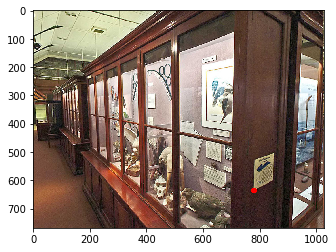

IMAGE 12
Point number 9
Coordinates point selected: (188,216)


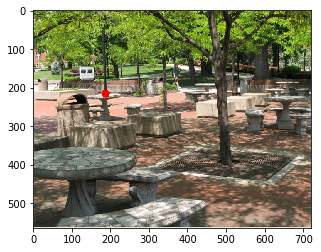

IMAGE 13
Point number 1
Coordinates point selected: (254,294)


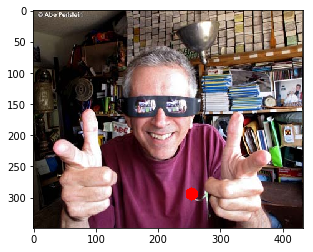

IMAGE 14
Point number 4
Coordinates point selected: (302,668)


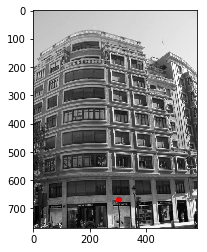

IMAGE 15
Point number 1
Coordinates point selected: (512,464)


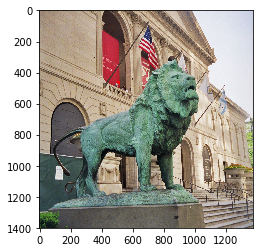

____________________________________________________________
IMAGE 21
0
[-0.000166   -0.00064159  0.41861409]
[16, 400, 1]


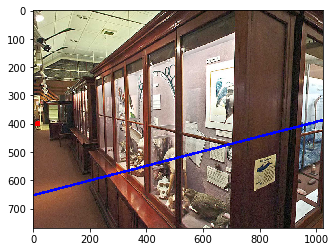

____________________________________________________________
IMAGE 22
1
[ 0.00027386  0.00055191 -0.23441817]
[334, 180, 1]


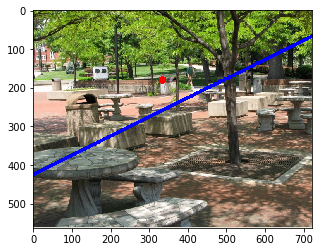

____________________________________________________________
IMAGE 23
2
[-0.00056768 -0.00111412  0.34747525]
[254, 294, 1]


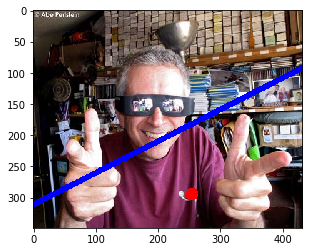

____________________________________________________________
IMAGE 24
3
[ 0.00042884  0.00019016 -0.28997224]
[380, 113, 1]


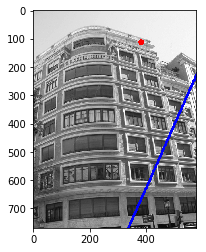

____________________________________________________________
IMAGE 25
4
[ 0.0003289   0.00011559 -0.37023307]
[512, 464, 1]


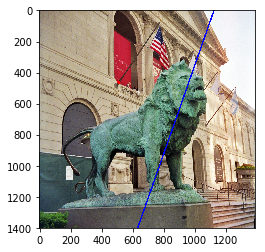

In [50]:
for idx in range(query_num+image_num):
    if idx == 0:
        index_point_selected = 9
    if idx == 1:
        index_point_selected = 9
    if idx == 2:
        index_point_selected = 1
    if idx == 3:
        index_point_selected = 4
    if idx == 4:
        index_point_selected = 1
        
    if idx < query_num:
        print("IMAGE 1{}".format(idx+1))
        img_dir = os.path.join(query_path,"image{}.png".format(idx+1))
        i = idx
       # F0 = torch.load("results/fundamental_matrix_0_images_pair_{}".format(idx+1))
        F2 = torch.load("results/fundamental_matrix_2_images_pair_{}".format(idx+1))
        X = X1[i][index_point_selected]
        print("Point number {}".format(index_point_selected))
        print("Coordinates point selected: ({},{})".format(X[0],X[1]))
        image = cv2.imread(img_dir)
        img= cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        cv2.circle(img,(X[0],X[1]), 10, (255,0,0), -1)

    else:
        print('____________________________________________________________')
        print("IMAGE 2{}".format(idx+1-query_num))
        img_dir = os.path.join(image_path,"image{}.png".format(idx+1-query_num))
        #F0 = torch.load("results/fundamental_matrix_0_images_pair_{}".format(idx+1-query_num))
        F2 = torch.load("results/fundamental_matrix_2_images_pair_{}".format(idx+1-query_num))
        i = idx+1-query_num-1
        print(i)
        X = X1[i][index_point_selected]
        image = cv2.imread(img_dir)
        img= cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

        l20 = np.dot(F2, X)
        print(l20)

        print(X)
        cv2.circle(img,(X[0],X[1]), 10, (255,0,0), -1)

        x_10 = 0
        y_10 = int((-l20[2])/(l20[1]))
        x_20 = int((-l20[2])/(l20[0]))
        y_20 = 0

        cv2.line(img,(x_10,y_10),(x_20,y_20),(0,0,255),8)

        

    plt.imshow(img)
    plt.show()